**Team ID**: 58
    
**Members Name**
* Hailin Du, hdu78, 903759918 
* Yue Wang, ywang4196, 903846815 

**Project Draft**:
Contrastive Learning of Medical Visual Representations from Paired Images and Text (Index 126)

**Introduction**

The original paper, "Contrastive Learning of Medical Visual Representations from Paired Images and Text," introduces ConVIRT, a new methodology designed to enhance visual representation learning in medical images. This approach leverages the benefits of learning from text data and unsupervised statistical methods. It uses the consistency between random real images and text data to pair the framework of visual representation. The paper's objective was to evaluate ConVIRT by transferring the pre-trained encoder weights to four different medical image classification tasks across two medical specialties. The goal was to demonstrate that the ConVIRT model is superior to all baseline initialization methods. To verify this conclusion, we will create several models that use image and text encoding to process paired image and text datasets, focusing to achieve higher accuracy in assisting radiologists with multiple image classification tasks.

Building on the previous draft of the paper, we have realized that replicating the text-encoding component for CheXpert images is unfeasible without radiology experts to create a comprehensive image-text pair dataset. Moreover, other models that could serve as competitive benchmarks require in-domain knowledge to create medical paired text and images with features such as text captioning or restructuring the later layers of the model. As a result, our original goal has shifted from merely replicating the paper to verifying it with experiments that introduce new models such as **DenseNet** and **Xception**, in addition to exploring **ResNet50** with both its default **Random Initialization** and **ImageNet Initialization**, as well as **ResNet18** from the paper, focusing on Image Classification.

Furthermore, we will explore four different datasets using all models: 1) CheXpert image classification, 2) MURA bony abnormality detection, 3) COVIDx, and 4) RSNA Pneumonia Detection. All these datasets consist of radiographic images, which will provide a clear idea of how these models perform and allow us to verify whether the model with paired text is as effective as claimed in the paper. We will record the metrics of accuracy, precision, recall and F1 score as our metrics to evaluate these models.

**Scope of Reproducibility**

Firstly, our focus will be on analyzing the CheXpert dataset using a ResNet50 model without ImageNet pretraining. Subsequently, we will conduct experiments with ResNet18 and ResNet50 models that incorporate ImageNet pretraining. Additionally, we plan to extend our analysis to other datasets mentioned in the paper, including the RSNA Pneumonia Detection, MURA, and COVIDx datasets. For these, we will employ additional models such as DenseNet and Xception.

Our hypotheses are outlined as follows:

1.	The ResNet with additional layer (ResNet 152) may not outperform Resnet 18 due to the result from previous project draft stage with minimum sample size and epochs.
2.	Introduction of DensenNet, Xception or VGG, at least one of these newly added models will outperform Resnet
3.	The performance of models depends on the datasets as all these models are trained on pretrained models of ImageNet Dataset.

**Methodology**

We will begin by importing all necessary packages and conducting an exploratory data analysis (EDA) of the CheXpert dataset. Following this, we will load the ResNet18 and ResNet50 models for our experiments. Later, we will introduce additional models such as DenseNet and Xception, all based on convolutional neural networks. After successfully verifying the performance on the CheXpert dataset, we will apply the same methodology to the MURA bony abnormality detection, COVIDx, and RSNA Pneumonia Detection datasets, conducting simple exploratory data analysis and evaluating model performance using these models.

In [1]:
# import packages, including resnet18 and rsenet50

import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import pydicom

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50, resnet152, densenet121, densenet201, vgg19
import timm
import torch.nn as nn
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split

D:\Software\anaconda3\envs\paper\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**CheXpert Image Classification - Exploratory Data Analysis (EDA)**

We will be using the CheXpert downsampled dataset. The original CheXpert dataset is a large public dataset for chest radiograph interpretation, consisting of 224,316 chest radiographs of 65,240 patients. Radiologists can make 14 observations as positive, negative, or uncertain.

The CheXpert-v1.0-small downsampled version consists of only 11.47 GB, with the training set comprising 223,414 images/labels and the validation set comprising 234 images/labels. We will start by conducting some exploratory data analysis (EDA) of the downsampled dataset.

The dataset source can be obtained from: https://www.kaggle.com/datasets/willarevalo/chexpert-v10-small.

**Noted**: Exploratory Data Analysis of the CheXpert dataset and the construction of ResNet 18 and ResNet 50 models were completed during the Project Draft stage.

In [2]:
# define path
path = 'D:/chexpert/CheXpert-v1.0-small/'

# reading data
train_df = pd.read_csv(f'{path}train.csv')
valid_df = pd.read_csv(f'{path}valid.csv')

train_df.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


As we have observed, the 14 labels contain missing values. At this point, we will replace NaN with 0, which will indicate a negative diagnosis.

In [3]:
# defining label cols
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
              'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
              'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
              'Support Devices']

# fill NaNs with 0 for label columns
train_df[label_cols] = train_df[label_cols].fillna(0)
valid_df[label_cols] = valid_df[label_cols].fillna(0)

train_df.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



---------Length of Training and Validation ---------
Training: 223414 
Validation: 234

---------Age Statistics---------
count    223414.000000
mean         60.430653
std          17.820925
min           0.000000
25%          49.000000
50%          62.000000
75%          74.000000
max          90.000000
Name: Age, dtype: float64


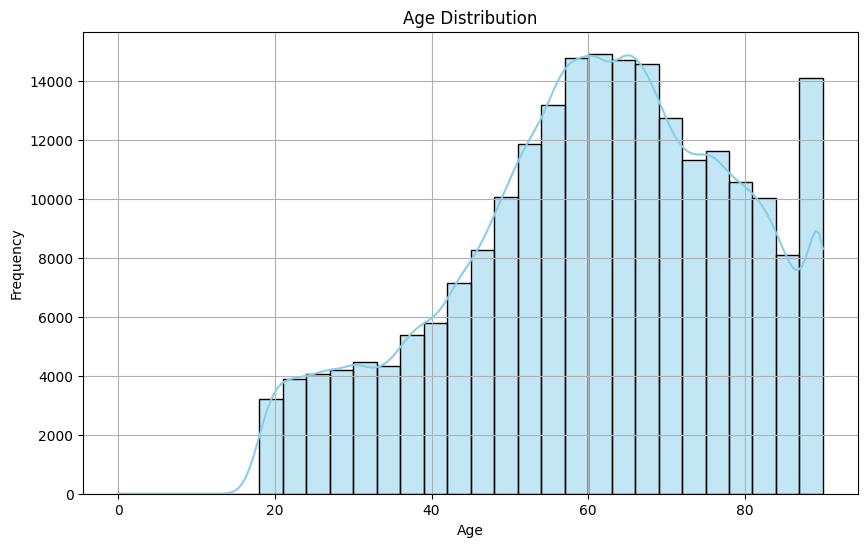

In [4]:
# train and valid info
print('\n---------Length of Training and Validation ---------')
print('Training: ' + str(len(train_df)), '\nValidation: ' + str(len(valid_df)))

# age statistics
print('\n---------Age Statistics---------')
print(train_df['Age'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

---------Counts of Positive Diagnoses for Each Condition---------
Support Devices               116001
Lung Opacity                  105581
Pleural Effusion               86187
Edema                          52246
Atelectasis                    33376
Cardiomegaly                   27000
No Finding                     22381
Pneumothorax                   19448
Consolidation                  14783
Enlarged Cardiomediastinum     10798
Lung Lesion                     9186
Fracture                        9040
Pneumonia                       6039
Pleural Other                   3523
dtype: int64


C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\3874729293.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_counts_series.values, y=positive_counts_series.index, palette='viridis')


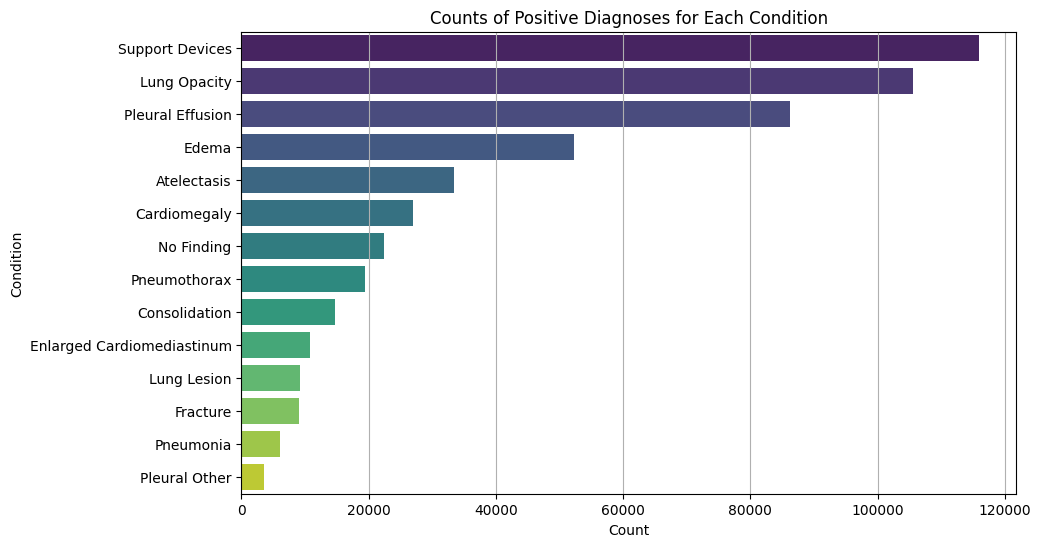

In [5]:
# count of positive dianoses
positive_counts = {}
for label in label_cols:
    # counting only positive 1.0
    count = train_df[label].value_counts().get(1.0, 0)
    positive_counts[label] = count

# convert the dictionary to pandas
positive_counts_series = pd.Series(positive_counts).sort_values(ascending=False)

print("---------Counts of Positive Diagnoses for Each Condition---------")
print(positive_counts_series)

plt.figure(figsize=(10, 6))
sns.barplot(x=positive_counts_series.values, y=positive_counts_series.index, palette='viridis')
plt.title('Counts of Positive Diagnoses for Each Condition')
plt.xlabel('Count')
plt.ylabel('Condition')
plt.grid(axis='x')
plt.show()

---------Sex distribution---------
 Sex
Male       132636
Female      90777
Unknown         1
Name: count, dtype: int64


C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\55937484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=train_df, palette='coolwarm')


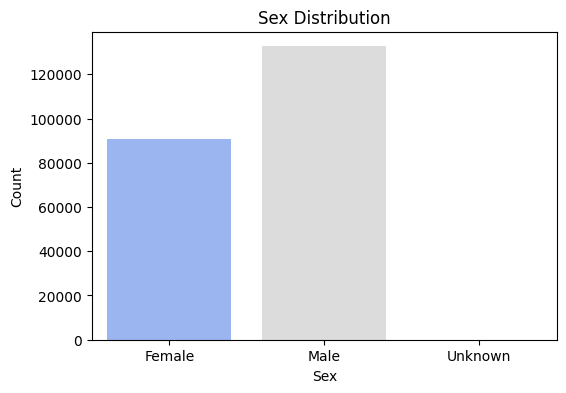

In [6]:
# sex/gender distribution
print("---------Sex distribution---------\n", train_df['Sex'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=train_df, palette='coolwarm')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

---------Frontal/Lateral distribution---------
 Frontal/Lateral
Frontal    191027
Lateral     32387
Name: count, dtype: int64


C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\1572460021.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Frontal/Lateral', data=train_df, palette='Set2')


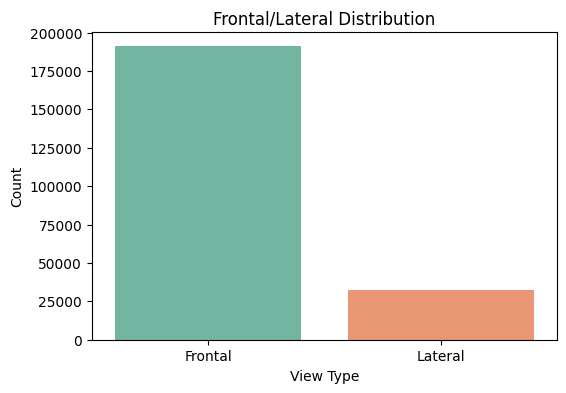

In [7]:
# Frontal/Lateral distribution
print("---------Frontal/Lateral distribution---------\n", train_df['Frontal/Lateral'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='Frontal/Lateral', data=train_df, palette='Set2')
plt.title('Frontal/Lateral Distribution')
plt.xlabel('View Type')
plt.ylabel('Count')
plt.show()

---------AP/PA distribution---------
 AP/PA
AP     161590
NaN     32387
PA      29420
LL         16
RL          1
Name: count, dtype: int64


C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\2676830655.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AP/PA', data=train_df, palette='Set3', order=train_df['AP/PA'].value_counts(dropna=False).index)


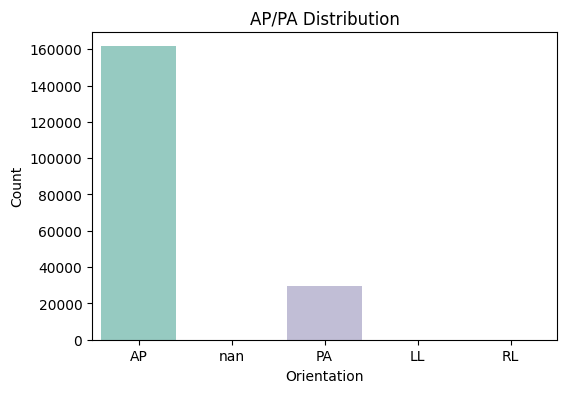

In [8]:
# AP/PA distribution
print("---------AP/PA distribution---------\n", train_df['AP/PA'].value_counts(dropna=False))

plt.figure(figsize=(6, 4))
sns.countplot(x='AP/PA', data=train_df, palette='Set3', order=train_df['AP/PA'].value_counts(dropna=False).index)
plt.title('AP/PA Distribution')
plt.xlabel('Orientation')
plt.ylabel('Count')
plt.show()

---------Diagnoses Distribution by Sex---------
           No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
Sex                                                                             
Female      9269.0000                 3962.000000  10524.000000  43234.000000   
Male       13111.0000                 6836.000000  16476.000000  62347.000000   
Unknown        1.0000                    0.000000      0.000000      0.000000   
M:F Ratio      1.4145                    1.725391      1.565564      1.442083   

           Lung Lesion         Edema  Consolidation    Pneumonia  \
Sex                                                                
Female     3810.000000  22174.000000     6064.00000  2482.000000   
Male       5376.000000  30072.000000     8719.00000  3557.000000   
Unknown       0.000000      0.000000        0.00000     0.000000   
M:F Ratio     1.411024      1.356183        1.43783     1.433118   

            Atelectasis  Pneumothorax  Pleural Effusion 

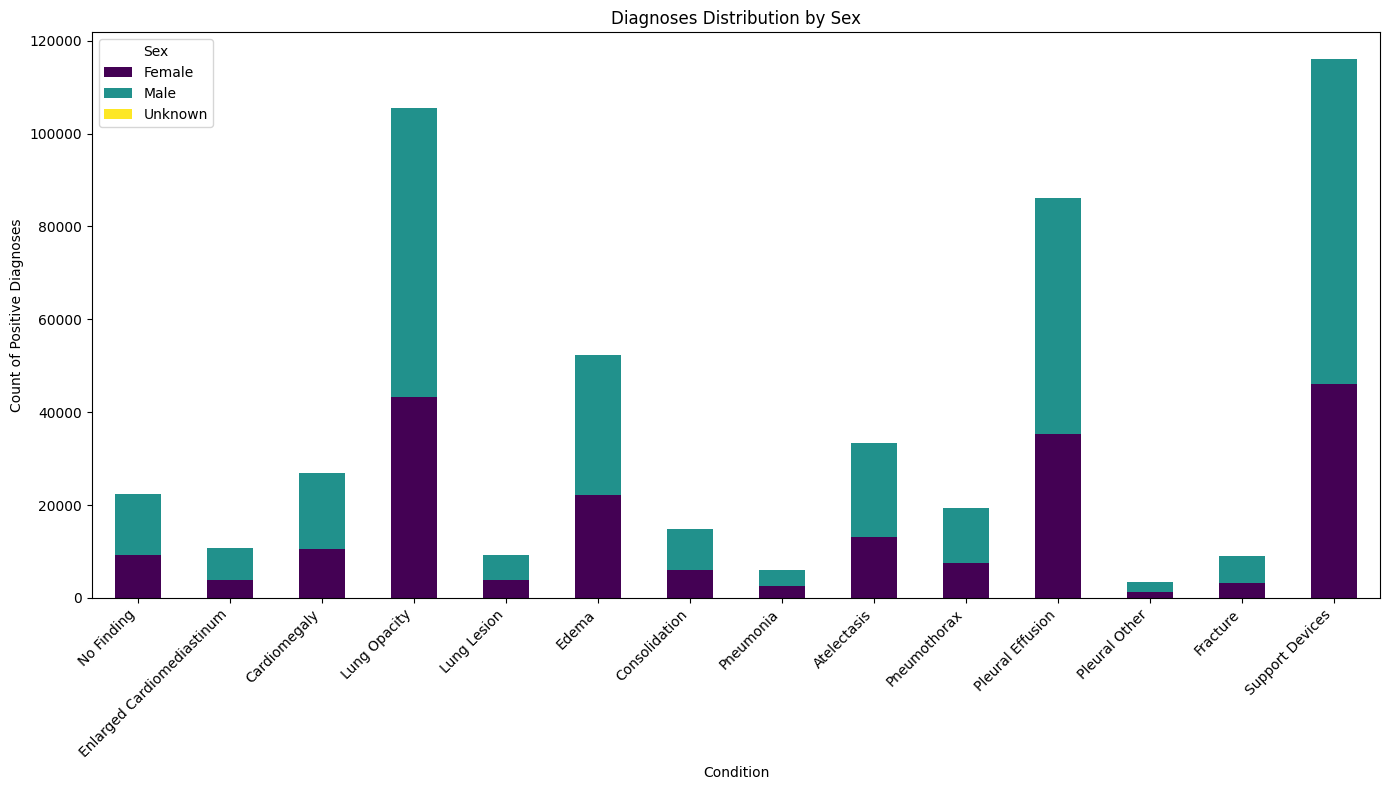

In [9]:
print("---------Diagnoses Distribution by Sex---------")

# counts by sex
diagnosis_by_sex = {}

for label in label_cols:
    # filter dataset for positive
    positive_cases = train_df[train_df[label] == 1.0]
    
    # count positive cases by sex
    sex_counts = positive_cases['Sex'].value_counts()
    diagnosis_by_sex[label] = sex_counts

# convert to DataFrame
diagnosis_by_sex_df = pd.DataFrame(diagnosis_by_sex).fillna(0)

# calculate ratios of male to female positive for each condition
diagnosis_by_sex_df.loc['M:F Ratio'] = diagnosis_by_sex_df.loc['Male'] / diagnosis_by_sex_df.loc['Female']

print(diagnosis_by_sex_df)

# remove the 'M:F Ratio'
diagnosis_counts_by_sex = diagnosis_by_sex_df.drop('M:F Ratio')

# plot
diagnosis_counts_by_sex.T.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Diagnoses Distribution by Sex')
plt.xlabel('Condition')
plt.ylabel('Count of Positive Diagnoses')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

---------Counts of 0, -1, and 1 for Each Condition---------
      No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
-1.0           0                       12403          8087          5598   
 0.0      201033                      200213        188327        112235   
 1.0       22381                       10798         27000        105581   

      Lung Lesion   Edema  Consolidation  Pneumonia  Atelectasis  \
-1.0         1488   12984          27742      18770        33739   
 0.0       212740  158184         180889     198605       156299   
 1.0         9186   52246          14783       6039        33376   

      Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
-1.0          3145             11628           2653       642             1079  
 0.0        200821            125599         217238    213732           106334  
 1.0         19448             86187           3523      9040           116001  


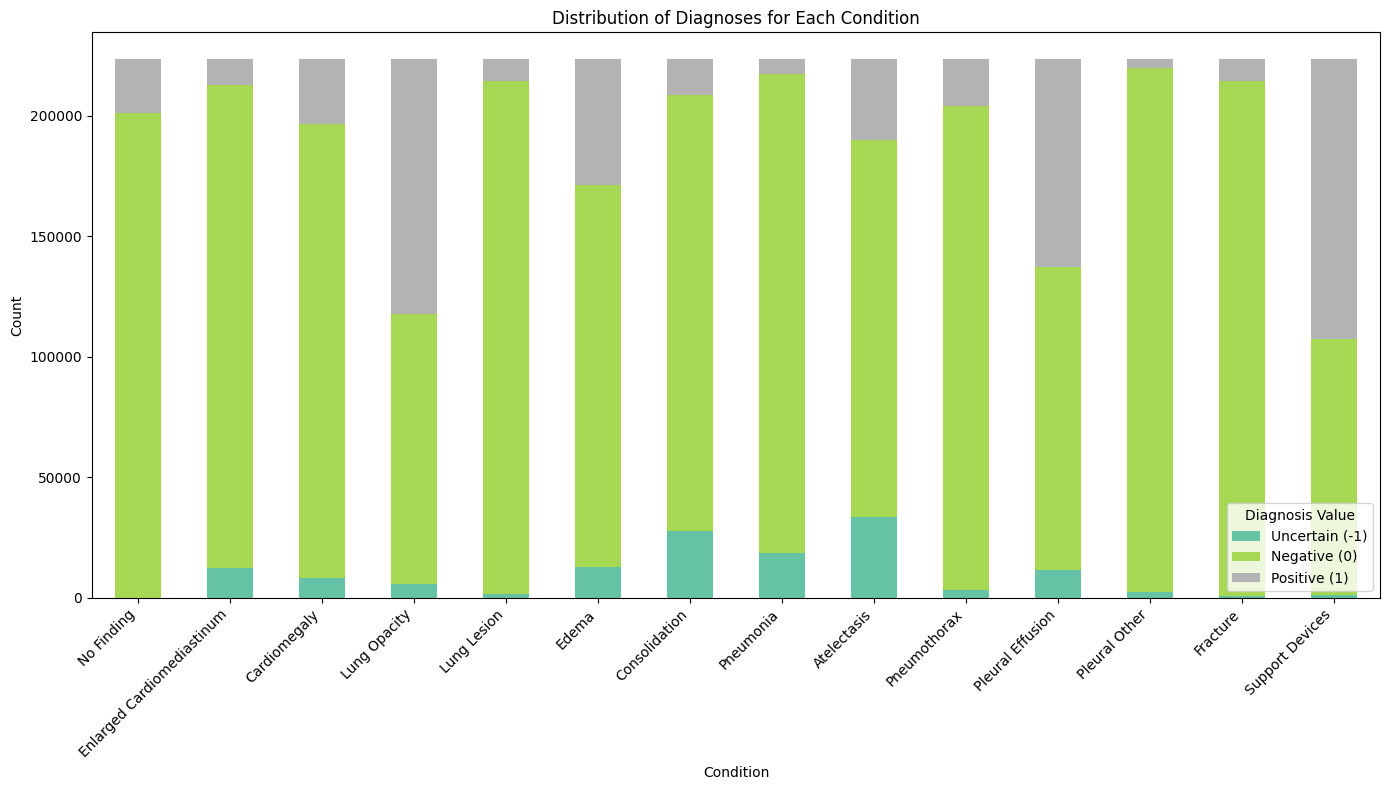

In [10]:
# hold the counts for each label
diagnosis_counts = {label: train_df[label].value_counts() for label in label_cols}

# convert to DataFrame
diagnosis_counts_df = pd.DataFrame(diagnosis_counts).fillna(0).astype(int)

print("---------Counts of 0, -1, and 1 for Each Condition---------")
print(diagnosis_counts_df)

# plot
diagnosis_counts_df.T.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')
plt.title('Distribution of Diagnoses for Each Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Diagnosis Value', labels=['Uncertain (-1)', 'Negative (0)', 'Positive (1)'])
plt.tight_layout()
plt.show()

---------Counts in Each Age Range---------
Age Range
0-9          3
10-19      766
20-29    13263
30-39    15499
40-49    24344
50-59    41966
60-69    49047
70-79    39221
80-89    29702
90-99     9603
Name: count, dtype: int64


C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\3744375261.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_range_counts.index, y=age_range_counts.values, palette='Spectral')


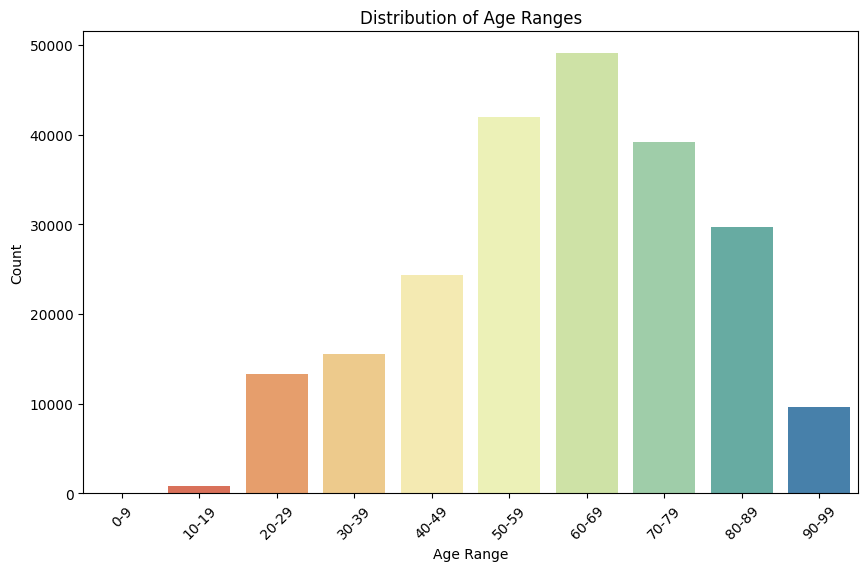

In [11]:
# age bins and labels
age_bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

# classify ages into bins
train_df['Age Range'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=False)

# count the number of each age range
age_range_counts = train_df['Age Range'].value_counts().sort_index()

print("---------Counts in Each Age Range---------")
print(age_range_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=age_range_counts.index, y=age_range_counts.values, palette='Spectral')
plt.title('Distribution of Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

---------Counts of Positive Diagnoses for Each Condition by Age Range---------
           No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
Age Range                                                                       
0-9                 1                           0             1             1   
10-19             146                          41            63           254   
20-29            2864                         644          1104          4959   
30-39            3046                         787          1515          6191   
40-49            3774                        1165          2300         10284   
50-59            4720                        1875          4354         19004   
60-69            4055                        2409          5576         23837   
70-79            2264                        1966          5184         19969   
80-89            1226                        1441          4957         15653   
90-99             285         

C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\1784274363.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_by_age_range_df.index, y=condition_by_age_range_df['Cardiomegaly'], palette='RdYlBu')


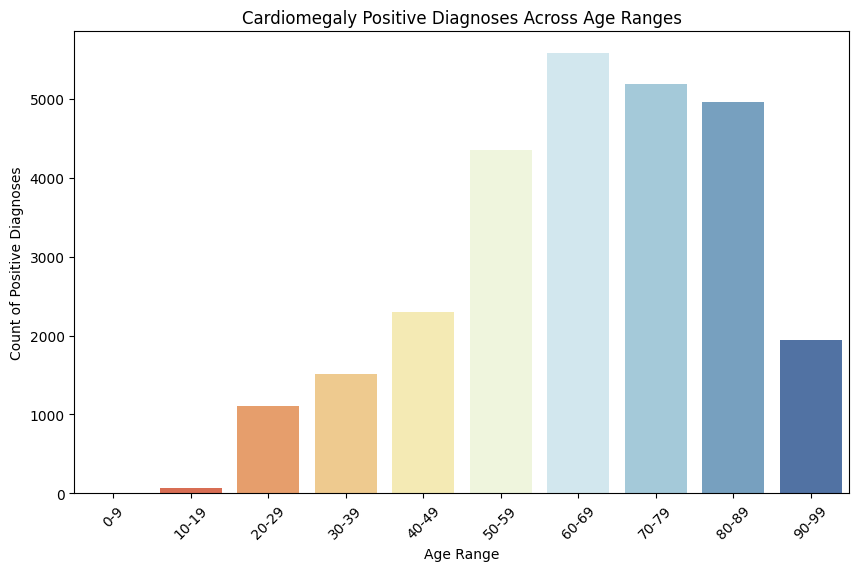

C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\1784274363.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_by_age_range_df.index, y=condition_by_age_range_df['Support Devices'], palette='RdYlGn')


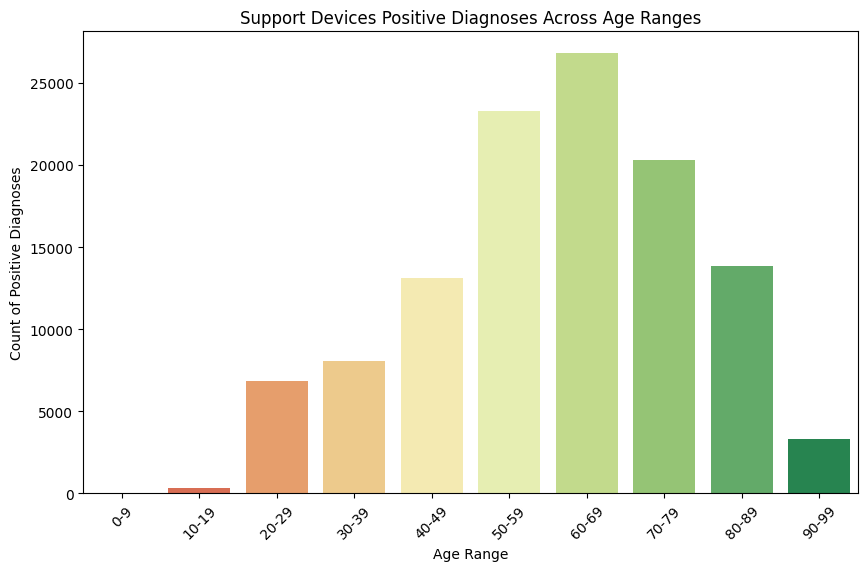

C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\1784274363.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_by_age_range_df.index, y=condition_by_age_range_df['Fracture'], palette='BrBG')


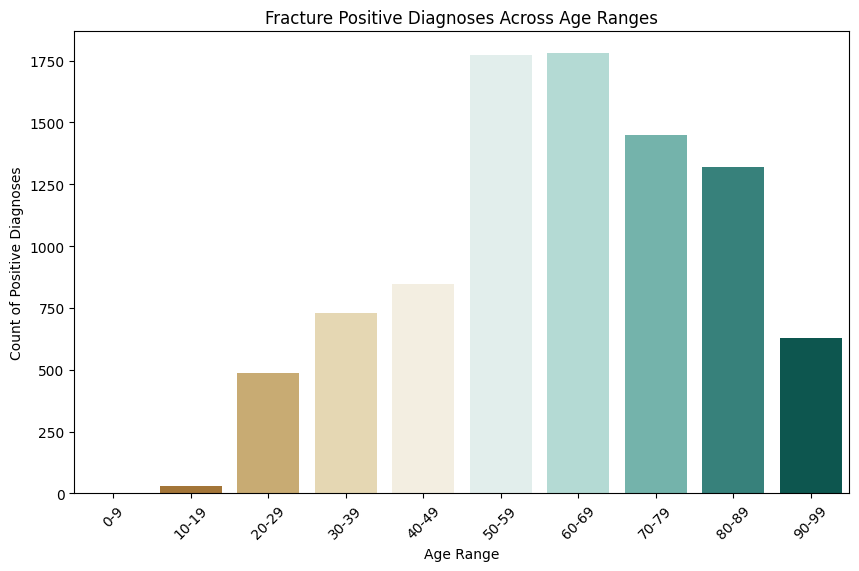

In [12]:
# hold counts of positive for each age range
condition_by_age_range = {label: train_df[train_df[label] == 1.0]['Age Range'].value_counts().sort_index() for label in label_cols}

# convert to Dataframe
condition_by_age_range_df = pd.DataFrame(condition_by_age_range).fillna(0).astype(int)

print("---------Counts of Positive Diagnoses for Each Condition by Age Range---------")
print(condition_by_age_range_df)

# plot Cardiomegaly counts across age ranges with color blue
plt.figure(figsize=(10, 6))
sns.barplot(x=condition_by_age_range_df.index, y=condition_by_age_range_df['Cardiomegaly'], palette='RdYlBu')
plt.title('Cardiomegaly Positive Diagnoses Across Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Count of Positive Diagnoses')
plt.xticks(rotation=45)
plt.show()

# plot Support Devices counts across age ranges with color green
plt.figure(figsize=(10, 6))
sns.barplot(x=condition_by_age_range_df.index, y=condition_by_age_range_df['Support Devices'], palette='RdYlGn')
plt.title('Support Devices Positive Diagnoses Across Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Count of Positive Diagnoses')
plt.xticks(rotation=45)
plt.show()

# plot Fracture counts across age ranges with color brown
plt.figure(figsize=(10, 6))
sns.barplot(x=condition_by_age_range_df.index, y=condition_by_age_range_df['Fracture'], palette='BrBG')
plt.title('Fracture Positive Diagnoses Across Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Count of Positive Diagnoses')
plt.xticks(rotation=45)
plt.show()

**Exploratory Data Analysis (EDA) Findings**

Based on our EDA findings, here are several key highlights of what we have observed:

* The CheXpert downsampled dataset predominantly includes the age group of **49 to 74**, especially observing that the range of **60-69 is the dominant age group**, showcasing conditions such as Cardiomegaly, Support Devices, and Fractures.
* The dominant radiographic findings in the dataset with positive diagnoses include **Support Devices** at 116,001, followed by **Lung Opacity** at 105,581, and **Pleural Effusion** at 86,187.
* The sex distribution is **predominantly male over female**, with males numbering 132,636, while females total 90,777, resulting in a ratio of **1.461**.
* Radiographic images are **predominantly frontal**, totaling 191,027, whereas lateral images number only 32,387.
* For radiographic views, AP views total 161,590 and PA views 29,420. Surprisingly, the dataset contains **32,387 missing values**, 16 labeled as Left Lateral, and 1 as Right Lateral.
* Across all conditions, the highest ratio of male to female diagnoses is for **Fractures**, at **1.911**, while the lowest is for **Edema**, at a ratio of **1.356**.
* The **most challenging diagnosis** is **Atelectasis**, with 33,739 cases marked as uncertain.

**Model Implementation (Random Init. & ImageNet Init.)** - Project Draft Stage

We will attempt to implement models focusing on a random initialization (without ImageNet pretraining) of ResNet50, as well as using ImageNet pretraining (set as true) with ResNet 18 and 50. 

We will define a CheXpert Dataset class to manage the CheXpert downsampled dataset, including data transformation, preprocessing, and data loaders. We also apply normalization and standard deviation in the transformation to improve convergence and stabilize gradient descent. Due to computational constraints, we will only be running the first 500 samples with 10 epochs for each model. Additionally, we have temporarily set uncertain labels to 0, classifying them as "negatives" at this point to simplify the implementation. 

We have chosen the Adam optimizer and a loss function of Binary Cross-Entropy with Logits. We are also using metrics such as accuracy, precision, recall, and F1-score during the training of each epoch. One of the important aspect here is that we are utilizing the GPU component on our local machine to ensure the training process is sufficiently fast.

**ResNet**

ResNet is a type of convolutional neural network (CNN) architecture designed to speed up the training of networks. The core idea behind ResNet is the introduction of skip connections or residual connections that allow the gradient to flow through the network more effectively, therefore, enable the training of much deeper networks by relieving the vanishing gradient problem. 

**ResNet-18**

ResNet-18 is a variant of the ResNet architecture that consists of 18 layers.
* It begins with a single convolutional layer (conv1), followed by batch normalization, a ReLU activation function, and a max pooling layer.
* This is followed by 2 sets of convolutional blocks, each comprising two layers with skip connections. These are known as residual blocks. In ResNet-18, there are 4 such blocks for each set, making a total of 8 convolutional layers here.
* The network then concludes with an average pooling layer and a fully connected layer that outputs the final class predictions.
* In total, the network comprises 17 convolutional and fully connected layers, plus 1 additional layer if we count the initial max pooling layer, summing up to 18 layers.

**ResNet-50**

ResNet-50 is a more complex variant with 50 layers. Comapre to ResNet-18, which uses basic residual blocks, ResNet-50 uses bottleneck blocks to increase the network's depth without significantly increasing computational complexity.
* The architecture starts similarly with a convolutional layer, batch normalization, ReLU, and max pooling.
* Following this initial setup, ResNet-50 uses 4 sets of bottleneck blocks. Each bottleneck block consists of three layers, a 1x1 convolutional layer for dimension reduction, a 3x3 layer for processing, and another 1x1 layer to expand the dimensions back. These blocks also include skip connections.
* There are 3, 4, 6, and 3 bottleneck blocks in each of the 4 sets, which contributing to the most parts of the network's depth.
* The network finishes with an average pooling layer and a fully connected layer for class predictions. 
* The combination of convolutional and fully connected layers brings the total to 50 layers.

**ResNet-152**

ResNet-152 consists of 152 layers, expanding on the ResNet architecture for deeper neural networks.
* Begins with a single convolutional layer (conv1), followed by batch normalization, ReLU activation, and max pooling.
* Features four sets of bottleneck blocks to deepen the network efficiently. Each block in these sets comprises:
    * A 1x1 convolution for dimension reduction
    * A 3x3 convolution for processing
    * A 1x1 convolution to expand dimensions back, all featuring skip connections
* The sets of blocks include 3, 8, 36, and 3 blocks respectively.
* Concludes with an average pooling layer and a fully connected layer for class predictions.
* The architecture totals 152 layers, blending convolutional and fully connected layers.

**DenseNet-121**

DenseNet-121 includes 121 layers and is known for its dense connectivity pattern.

* Starts with a convolutional layer, followed by batch normalization, ReLU activation, and a pooling layer.
* Utilizes densely connected blocks where each layer connects to every other layer in a feed-forward fashion.
* Comprises four dense blocks with layer counts of 6, 12, 24, and 16.
* Each layer within the block is connected to every other layer, enhancing feature propagation.
* Ends with global average pooling and a fully connected classification layer.

**DenseNet-201**

DenseNet-201, an extension of DenseNet-121, includes 201 layers.

* Similar initial setup with a convolution, batch normalization, ReLU, and pooling.
* Contains more layers within its densely connected blocks: 6, 12, 48, and 32 in each respective block.
* Features extensive dense connectivity, improving the network's ability to leverage features from all previous layers.
* Finishes with global average pooling and a dense layer for output.

**Xception**
Xception incorporates 71 layers and uses depthwise separable convolutions for efficient computation.

* Starts with a standard convolutional layer, batch normalization, and ReLU activation.
* Follows with depthwise separable convolutions that divide the processing of channels and spatial dimensions, improving efficiency.
* Structured into flow of entry, middle, and exit flows with increasing depths.
* Concludes with average pooling and a fully connected layer to produce the output.

**VGG-19**

VGG-19 features 19 layers and is renowned for its simplicity and depth.
* Initiates with consecutive convolutional layers using small 3x3 filters, followed by max pooling operations.
* Comprises several blocks of convolutional layers, each block increasing in depth: from 64, 128, 256, to 512 filters.
* Follows a traditional architecture with repeated blocks of convolutions to deepen the network gradually.
* Ends with three fully connected layers and a final softmax output layer.

**Model 1 - Random Initialization**

ResNet 50 model (random initialization) without pretraining on ImageNet.

In [13]:
# path to the CheXpert dataset
path = 'D:/chexpert/CheXpert-v1.0-small/'
path2 = 'D:/chexpert/'

class CheXpertDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        
        # CheXpertDataset
        
        self.dataframe = dataframe # dataframe paths and labels
        self.root_dir = root_dir # root dir for image paths
        self.transform = transform # transformations

    def __len__(self):
        
        # total number of samples
        
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        # get single image
        
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['Path'])
        
        # convert to RGB image
        image = Image.open(img_path).convert('RGB')
        
        # convert labels to float
        labels = self.dataframe.iloc[idx][label_cols].values.astype(float)
        
        # replace uncertain labels -1 with 0
        labels[labels == -1] = 0 
        
        # covert to PyTorch tensor with datatpye float32
        labels = torch.tensor(labels, dtype=torch.float32)
        
        # apply transformations
        if self.transform:
            image = self.transform(image)
            
        # return transformed image and labels
        return image, labels

def calculate_metrics(y_true, y_scores):

    # calcualte accuracy, precision, recall, and F1
    
    accuracy = accuracy_score(y_true, y_scores > 0.5)
    precision = precision_score(y_true, y_scores > 0.5, average='micro')
    recall = recall_score(y_true, y_scores > 0.5, average='micro')
    f1 = f1_score(y_true, y_scores > 0.5, average='micro')
    auc = roc_auc_score(y_true, y_scores)
    
    return accuracy, precision, recall, f1, auc

def train_model(model, train_loader, criterion, optimizer, device, epochs=1):
    # loop over the training
    for epoch in range(epochs):
        model.train()  # model training mode
        total_loss = 0  # loss function start with 0
        all_labels = []  # store all labels
        all_scores = []  # store all raw scores for AUC calculation

        # loop over batches of training data
        for images, labels in train_loader:

            # move to GPU
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # clear the gradients
            outputs = model(images)  # compute model outputs
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # compute gradient of the loss
            optimizer.step()  # perform a single optimization step

            total_loss += loss.item()  # update total loss

            # store labels and raw output scores
            all_labels.append(labels.detach().cpu().numpy())
            all_scores.append(outputs.detach().cpu().numpy())

        # combine labels and predictions
        all_labels = np.concatenate(all_labels)
        all_scores = np.concatenate(all_scores)

        # convert raw scores to prob as binary classification
        all_probabilities = torch.sigmoid(torch.tensor(all_scores)).numpy()
        all_predictions = (all_probabilities > 0.5).astype(int)

        # calculate metrics including AUC
        accuracy, precision, recall, f1, auc = calculate_metrics(all_labels, all_scores)

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
        
def evaluate_model(model, test_loader, criterion, device):
    # model evaluation
    model.eval()
    
    # start with 0 for loss
    total_loss = 0
    
    # empty list to store
    all_labels = []
    all_predictions = []
    all_scores = []

    # no computing gardients
    with torch.no_grad():
        # loading test set
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # to CUDA device
            outputs = model(images) # compute model outputs
            loss = criterion(outputs, labels) # calculate loss
            total_loss += loss.item() # update total loss

            all_labels.append(labels.cpu().numpy()) # save the labels
            scores = torch.sigmoid(outputs).cpu().numpy() # compute scores
            all_predictions.append((scores > 0.5).astype(int)) # compute predictions with 0.5
            all_scores.append(scores) # save the predictions

    # combine labels, scores and predictions
    all_labels = np.concatenate(all_labels)
    all_scores = np.concatenate(all_scores)
    all_predictions = np.concatenate(all_predictions)

    # compute AUC for each label
    aucs = []
    for i in range(all_scores.shape[1]):
        ####### introduce error handle due to the subseted dataset AUC may not be able to calculate #######
        try:
            auc = roc_auc_score(all_labels[:, i], all_scores[:, i])
            aucs.append(auc)
        except ValueError:
            aucs.append(float('nan'))  # If only one class present or any other issue

    # calculate other metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    f1 = f1_score(all_labels, all_predictions, average='micro')

    # compute mean AUC, ignoring NaN values
    mean_auc = np.nanmean(aucs)

    # print out the results
    print(f"Test Loss: {total_loss / len(test_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1: {f1:.4f}, Mean AUC: {mean_auc:.4f}")
    
    # for future reference to dive deep into Confusion Matrix
    #return {'labels': all_labels, 'predictions': all_predictions, 'aucs': aucs}


In [14]:
# transformations to the image 
transform = transforms.Compose([transforms.Resize((224, 224)), # resize to 224 x 224
                                transforms.ToTensor(), # PyTorch tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # Noramlziation
                                                     std=[0.229, 0.224, 0.225]),]) # Standard Deviation

# first 500 rows of training and first 100 row of validation
train_df = pd.read_csv(f'{path}train.csv').iloc[:500]
valid_df = pd.read_csv(f'{path}valid.csv').iloc[:10]

# columns with labels
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
              'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
              'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
              'Support Devices']

# fill missing values with 0 in the label columns
train_df[label_cols] = train_df[label_cols].fillna(0)
valid_df[label_cols] = valid_df[label_cols].fillna(0)

# drop rows with any missing values in the training and validation
train_df = train_df.dropna()
valid_df = valid_df.dropna()

# create dataset for training and validation using CheXpertDataset
train_dataset = CheXpertDataset(train_df, path2, transform=transform)
valid_dataset = CheXpertDataset(valid_df, path2, transform=transform)

# create dataloader for both training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [15]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 without pretraining 
model = resnet50(pretrained=False)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Resnet 50 without pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet 50 without pretraining Training Set
Epoch 1, Loss: 0.4154, Accuracy: 0.0449, Precision: 0.4753, Recall: 0.1087, F1: 0.1770, AUC: 0.5083

Resnet 50 Test set
Test Loss: 0.9385, Accuracy: 0.0000, Precision: 0.3571, Recall: 0.4762, F1: 0.4082, Mean AUC: 0.6028


**Model 2 - ImageNet initialization 18**

ResNet 18 model (ImageNet initialization) with pretraining on the ImageNet dataset.

In [16]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 18 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Resnet 18 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 18 Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 18 with pretraining Training Set
Epoch 1, Loss: 0.3990, Accuracy: 0.0723, Precision: 0.6160, Recall: 0.2369, F1: 0.3422, AUC: 0.5743

Resnet 18 Test set
Test Loss: 0.8256, Accuracy: 0.0000, Precision: 0.2105, Recall: 0.1905, F1: 0.2000, Mean AUC: 0.7103


**Model 3 - ImageNet initialization 50**

ResNet 50 model (ImageNet initialization) with pretraining on the ImageNet dataset.

In [17]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 with pretraining 
model = resnet50(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Resnet 50 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 50 with pretraining Training Set
Epoch 1, Loss: 0.3876, Accuracy: 0.0474, Precision: 0.6361, Recall: 0.2349, F1: 0.3431, AUC: 0.5645

Resnet 50 Test set
Test Loss: 0.9341, Accuracy: 0.1250, Precision: 0.3000, Recall: 0.1429, F1: 0.1935, Mean AUC: 0.7169


**Model 4 - ImageNet initialization 152**

ResNet 152 model (ImageNet initialization) with pretraining on the ImageNet dataset.

In [18]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 152 with pretraining 
model = resnet152(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Resnet 152 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 152 Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 152 with pretraining Training Set
Epoch 1, Loss: 0.3936, Accuracy: 0.0449, Precision: 0.5875, Recall: 0.2308, F1: 0.3314, AUC: 0.5391

Resnet 152 Test set
Test Loss: 11.5013, Accuracy: 0.0000, Precision: 0.2564, Recall: 0.4762, F1: 0.3333, Mean AUC: 0.4778


**Model 5 - DenseNet 121**

DenseNet 121 model (ImageNet initialization) with pretraining on the ImageNet dataset.

In [19]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DenseNet 121 with pretraining 
model = densenet121(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier  = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('DenseNet 121 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 121 Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 121 with pretraining Training Set
Epoch 1, Loss: 0.3776, Accuracy: 0.0599, Precision: 0.6150, Recall: 0.2441, F1: 0.3495, AUC: 0.5976

DenseNet 121 Test set
Test Loss: 0.7855, Accuracy: 0.0000, Precision: 0.5000, Recall: 0.2381, F1: 0.3226, Mean AUC: 0.6518


**Model 6 - DenseNet 201**

DenseNet 201 model (ImageNet initialization) with pretraining on the ImageNet dataset.

In [20]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DenseNet with pretraining 
model = densenet201(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier  = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('DenseNet 201 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 201 Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 201 with pretraining Training Set
Epoch 1, Loss: 0.3791, Accuracy: 0.0648, Precision: 0.6667, Recall: 0.2113, F1: 0.3209, AUC: 0.5846

DenseNet 201 Test set
Test Loss: 2.9035, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Mean AUC: 0.4851


**Model 7 - Xception**

Xception model (ImageNet initialization) with pretraining on the ImageNet dataset.

In [21]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xception with pretraining 
model = timm.create_model('xception', pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, len(label_cols))

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Xception with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nXception Test set')
evaluate_model(model, valid_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception with pretraining Training Set
Epoch 1, Loss: 0.3926, Accuracy: 0.0623, Precision: 0.6562, Recall: 0.1938, F1: 0.2993, AUC: 0.5692

Xception Test set
Test Loss: 0.5299, Accuracy: 0.0000, Precision: 0.7500, Recall: 0.1429, F1: 0.2400, Mean AUC: 0.7421


**Model 8 - VGG 19**

VGG 19 (ImageNet initialization) with pretraining on the ImageNet dataset.

**Note**: We can also try to analyze the confusion matrix and visualize the performance of each condition to gain deeper insights by modifying the `evaluate_model` function to return labels and predictions.

In [22]:
# def plot_confusion_matrix_per_label(true_labels, predicted_labels, class_names):
#     num_labels = true_labels.shape[1]  # Assuming true_labels is a 2D array [samples, labels]
#     for i in range(num_labels):
#         cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
#         plt.figure(figsize=(5, 5))
#         sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#         plt.title(f'Confusion Matrix for {class_names[i]}')
#         plt.xlabel('Predicted')
#         plt.ylabel('True')
#         plt.show()

# plot_confusion_matrix_per_label(results['labels'], results['predictions'], label_cols)


**MURA Bony Abnormality Detection - Exploratory Data Analysis (EDA)**

We will be using the MURA dataset, a large collection of musculoskeletal radiographs that includes 40,561 images across 14,863 studies. Each study has been manually labeled by radiologists as either normal or abnormal. The dataset totals 3.37 GB in size. We will begin with a simple exploratory data analysis (EDA) of this dataset.

The dataset source can be obtained from: https://www.kaggle.com/datasets/cjinny/mura-v11/data.

In [23]:
# path to the MURA dataset
path = 'D:/chexpert/MURA/MURA-v1.1/'
train_df = pd.read_csv(f'{path}train_image_paths.csv', names = ['image_path'])
test_df = pd.read_csv(f'{path}valid_image_paths.csv', names = ['image_path'])

# data cleaning process for labels and categotry
def get_label(rec):
    return rec.split("/")[4].split('_')[1]

def get_categoty(rec):
    return rec.split('/')[2]

# loadding training and test set
train_df['label'] = train_df['image_path'].map(get_label)
train_df['category'] = train_df['image_path'].map(get_categoty)

test_df['label'] = test_df['image_path'].map(get_label)
test_df['category'] = test_df['image_path'].map(get_categoty)

# labels
label_cols = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND',
              'XR_HUMERUS','XR_SHOULDER','XR_WRIST']

# total size
print("Total Images:", len(train_df) + len(test_df))
print("Training Set:", len(train_df),"\nTest Set:", len(test_df))
print(train_df.head())

Total Images: 40005
Training Set: 36808 
Test Set: 3197
                                          image_path     label     category
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  positive  XR_SHOULDER
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  positive  XR_SHOULDER
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  positive  XR_SHOULDER
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...  positive  XR_SHOULDER
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...  positive  XR_SHOULDER



Total Counts by Category:
category
XR_ELBOW       4931
XR_FINGER      5106
XR_FOREARM     1825
XR_HAND        5543
XR_HUMERUS     1272
XR_SHOULDER    8379
XR_WRIST       9752
dtype: int64

Label Counts by Category:
label        negative  positive
category                       
XR_ELBOW         2925      2006
XR_FINGER        3138      1968
XR_FOREARM       1164       661
XR_HAND          4059      1484
XR_HUMERUS        673       599
XR_SHOULDER      4211      4168
XR_WRIST         5765      3987

Label Percentages by Category:
label         negative   positive
category                         
XR_ELBOW     59.318597  40.681403
XR_FINGER    61.457109  38.542891
XR_FOREARM   63.780822  36.219178
XR_HAND      73.227494  26.772506
XR_HUMERUS   52.908805  47.091195
XR_SHOULDER  50.256594  49.743406
XR_WRIST     59.116079  40.883921


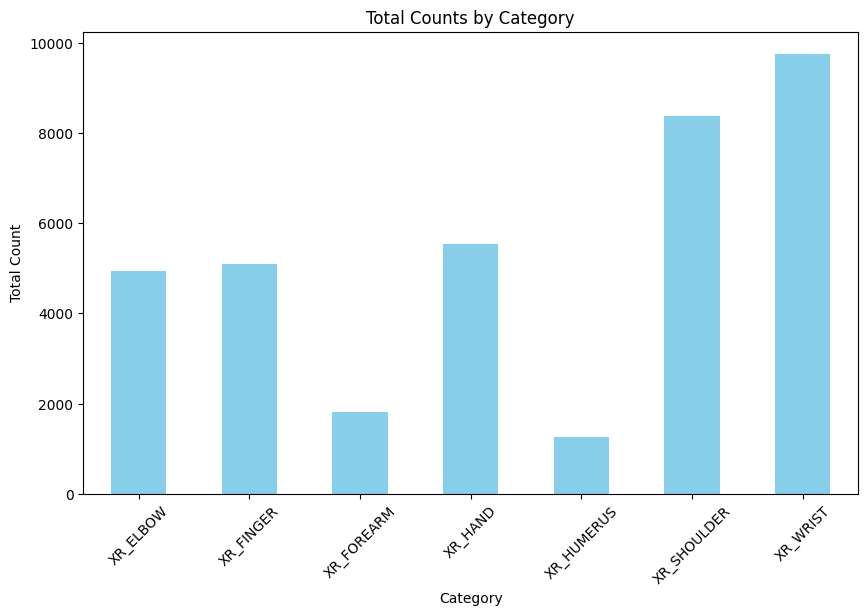

In [24]:
# group by category and label and count total
category_label_counts = train_df.groupby(['category', 'label']).size().unstack(fill_value=0)

# Calculate total counts per category
category_totals = train_df.groupby('category').size()

# total counts for each category
print("\nTotal Counts by Category:")
print(category_totals)

# label counts for each category
print("\nLabel Counts by Category:")
print(category_label_counts)

# calculate label percentages for each category
label_percentages = category_label_counts.div(category_totals, axis=0) * 100
print("\nLabel Percentages by Category:")
print(label_percentages)

# bar graph of total counts by category
plt.figure(figsize=(10, 6))
category_totals.plot(kind='bar', color='skyblue')
plt.title('Total Counts by Category')
plt.xlabel('Category')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.show()

In [25]:
class MURADataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe  # dataframe containing paths and labels
        self.root_dir = root_dir  # root directory for image paths
        self.transform = transform  # transformations to apply

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['image_path'])
        image = Image.open(img_path).convert('RGB')  # convert to RGB

        # Convert labels from categorical to tensor
        label = torch.tensor(self.dataframe.iloc[idx]['label'] == 'positive', dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return image, label
    
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    # loop over the training
    for epoch in range(epochs):
        model.train()  # model training mode
        total_loss = 0  # loss function start with 0
        all_labels = []  # store all labels
        all_scores = []  # store all raw scores for AUC calculation

        # loop over batches of training data
        for images, labels in train_loader:

            # move to GPU
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # clear the gradients
            outputs = model(images)  # compute model outputs
            outputs = outputs.squeeze(1) # squeeze the outputs to match label dimensions
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # compute gradient of the loss
            optimizer.step()  # perform a single optimization step

            total_loss += loss.item()  # update total loss

            # store labels and raw output scores
            all_labels.append(labels.detach().cpu().numpy())
            all_scores.append(outputs.detach().cpu().numpy())

        # combine labels and predictions
        all_labels = np.concatenate(all_labels)
        all_scores = np.concatenate(all_scores)

        # convert raw scores to prob as binary classification
        all_probabilities = torch.sigmoid(torch.tensor(all_scores)).numpy()
        all_predictions = (all_probabilities > 0.5).astype(int)

        # calculate metrics including AUC
        accuracy, precision, recall, f1, auc = calculate_metrics(all_labels, all_scores)

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
        
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_labels = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # compute output
            outputs = outputs.squeeze(1)  # adjust output dimensions
            loss = criterion(outputs, labels) # caluclate loss
            total_loss += loss.item() # compute for total loss
            
            all_labels.extend(labels.cpu().numpy())
            scores = torch.sigmoid(outputs).cpu().numpy()  # convert outputs to probabilities
            all_scores.extend(scores)
            predictions = (scores > 0.5).astype(int)
            all_predictions.extend(predictions)

    # calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    auc = roc_auc_score(all_labels, all_scores)

    # printing
    print(f"Test Loss: {total_loss / len(test_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

**Elbow Model 1 - Random Initialization**

**Elbow Model 2 - ImageNet initialization 18**

**Elbow Model 3 - ImageNet initialization 50**

**Elbow Model 4 - ImageNet initialization 152**

**Elbow Model 5 - DenseNet 121**

**Elbow Model 6 - DenseNet 201**

**Elbow Model 7 - Xception**

**Elbow Model 8 - VGG 19**

**Finger Model 1 - Random Initialization**

**Finger Model 2 - ImageNet initialization 18**

**Finger Model 3 - ImageNet initialization 50**

**Finger Model 4 - ImageNet initialization 152**

**Finger Model 5 - DenseNet 121**

**Finger Model 6 - DenseNet 201**

**Finger Model 7 - Xception**

**Finger Model 8 - VGG 19**

**Forearm Model 1 - Random Initialization**

**Forearm Model 2 - ImageNet initialization 18**

**Forearm Model 3 - ImageNet initialization 50**

**Forearm Model 4 - ImageNet initialization 152**

**Forearm Model 5 - DenseNet 121**

**Forearm Model 6 - DenseNet 201**

**Forearm 7 - Xception**

**Forearm 8 - VGG 19**

**Hand Model 1 - Random Initialization**

**Hand Model 2 - ImageNet initialization 18**

**Hand Model 3 - ImageNet initialization 50**

**Hand Model 4 - ImageNet initialization 152**

**Hand Model 5 - DenseNet 121**

**Hand Model 6 - DenseNet 201**

**Hand 7 - Xception**

**Hand 8 - VGG 19**

**Humerus Model 1 - Random Initialization**

**Humerus Model 2 - ImageNet initialization 18**

**Humerus Model 3 - ImageNet initialization 50**

**Humerus Model 4 - ImageNet initialization 152**

**Humerus Model 5 - DenseNet 121**

**Humerus Model 6 - DenseNet 201**

**Humerus 7 - Xception**

**Humerus 8 - VGG 19**

In [26]:
XR_SHOULDER_train_df = train_df[train_df['category'] == label_cols[5]].reset_index(drop = True).drop("category", axis = 1)
XR_SHOULDER_test_df = test_df[test_df['category'] == label_cols[5]].reset_index(drop = True).drop("category", axis = 1)

# shuffle test df
XR_SHOULDER_test_df = XR_SHOULDER_test_df.sample(frac=1, random_state=123)
XR_SHOULDER_test_df = XR_SHOULDER_test_df[:100]

###### change the varaible ######
label_counts = XR_SHOULDER_train_df['label'].value_counts()

print("\nShoulder Label Counts:")
print(label_counts)

###### change the varaible ######
print("\nShoulder Label Percentages:")
label_subset = label_counts / len(XR_SHOULDER_train_df) * 100
print(label_subset)

# get sample number of negative and positive samples
total_samples = 100
percent_negative = label_subset[0] / 100
percent_positive = label_subset[1] / 100

# calculate the porportion
num_negative = int(total_samples * percent_negative)
num_positive = total_samples - num_negative

###### change the varaible ###### - sample negative and positive rows
negative_samples = XR_SHOULDER_train_df[XR_SHOULDER_train_df['label'] == 'negative'].sample(n=num_negative, random_state=123)
positive_samples = XR_SHOULDER_train_df[XR_SHOULDER_train_df['label'] == 'positive'].sample(n=num_positive, random_state=123)

# combine samples and shuffle
subset_df = pd.concat([negative_samples, positive_samples]).sample(frac=1, random_state=123).reset_index(drop=True)

# label counts and percentages in the new subset
label_counts = subset_df['label'].value_counts()
print("\nLabel Counts in Subset:")
print(label_counts)

print("\nLabel Percentages to Subset:")
print(label_subset)

print("\nLabel Percentages in Subset:")
label_subseted = label_counts / len(subset_df) * 100
print(label_subseted)


Shoulder Label Counts:
label
negative    4211
positive    4168
Name: count, dtype: int64

Shoulder Label Percentages:
label
negative    50.256594
positive    49.743406
Name: count, dtype: float64

Label Counts in Subset:
label
negative    50
positive    50
Name: count, dtype: int64

Label Percentages to Subset:
label
negative    50.256594
positive    49.743406
Name: count, dtype: float64

Label Percentages in Subset:
label
negative    50.0
positive    50.0
Name: count, dtype: float64


C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\4170508530.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_negative = label_subset[0] / 100
C:\Users\ninep\AppData\Local\Temp\ipykernel_66516\4170508530.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_positive = label_subset[1] / 100


**Shoulder Model 1 - Random Initialization**

In [27]:
transform = transforms.Compose([transforms.Resize((224, 224)), # resize to 224 x 224
                                transforms.ToTensor(), # PyTorch tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # noramlziation
                                                     std=[0.229, 0.224, 0.225]),]) # standard deviation

path2 = 'D:/chexpert/MURA/'

###### change the varaible ######
train_dataset = MURADataset(subset_df, path2, transform=transform)
test_dataset = MURADataset(XR_SHOULDER_test_df, path2, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 without pretraining 
model = resnet50(pretrained=False)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 50 without pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet 50 without pretraining Training Set
Epoch 1, Loss: 1.0340, Accuracy: 0.4700, Precision: 0.4700, Recall: 0.4700, F1: 0.4700, AUC: 0.4656

Resnet 50 Test set
Test Loss: 0.8896, Accuracy: 0.5700, Precision: 0.5700, Recall: 1.0000, F1: 0.7261, AUC: 0.4206


**Shoulder Model 2 - ImageNet initialization 18**

In [28]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 18 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 18 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 18 Test set')
evaluate_model(model, test_loader, criterion, device)

Resnet 18 with pretraining Training Set

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1, Loss: 1.0253, Accuracy: 0.5800, Precision: 0.5800, Recall: 0.5800, F1: 0.5800, AUC: 0.5976

Resnet 18 Test set
Test Loss: 1.3184, Accuracy: 0.5500, Precision: 0.5625, Recall: 0.9474, F1: 0.7059, AUC: 0.6197


**Shoulder Model 3 - ImageNet initialization 50**

In [29]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 50 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 50 with pretraining Training Set
Epoch 1, Loss: 0.8768, Accuracy: 0.6100, Precision: 0.6100, Recall: 0.6100, F1: 0.6100, AUC: 0.6408

Resnet 50 Test set
Test Loss: 2.2454, Accuracy: 0.5600, Precision: 0.5699, Recall: 0.9298, F1: 0.7067, AUC: 0.6752


**Shoulder Model 4 - ImageNet initialization 152**

In [30]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 152 with pretraining 
model = resnet152(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 152 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 152 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 152 with pretraining
Epoch 1, Loss: 1.0006, Accuracy: 0.5000, Precision: 0.5000, Recall: 0.5000, F1: 0.5000, AUC: 0.5024

Resnet 152 Test set
Test Loss: 9.3839, Accuracy: 0.4700, Precision: 0.5256, Recall: 0.7193, F1: 0.6074, AUC: 0.4782


**Shoulder Model 5 - DenseNet 121**

In [31]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # DenseNet 121 with pretraining 
model = densenet121(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('DenseNet 121 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 121 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 121 with pretraining
Epoch 1, Loss: 0.7256, Accuracy: 0.6100, Precision: 0.6100, Recall: 0.6100, F1: 0.6100, AUC: 0.6280

DenseNet 121 Test set
Test Loss: 0.7885, Accuracy: 0.5400, Precision: 0.5846, Recall: 0.6667, F1: 0.6230, AUC: 0.5614


**Shoulder Model 6 - DenseNet 201**

In [32]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # DenseNet 201 with pretraining 
model = densenet201(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('DenseNet 201 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 201 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 201 with pretraining
Epoch 1, Loss: 0.7768, Accuracy: 0.5800, Precision: 0.5800, Recall: 0.5800, F1: 0.5800, AUC: 0.5700

DenseNet 201 Test set
Test Loss: 1.2507, Accuracy: 0.5600, Precision: 0.6000, Recall: 0.6842, F1: 0.6393, AUC: 0.5606


**Shoulder Model 7 - Xception**

In [33]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xception with pretraining 
model = timm.create_model('xception', pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Xception with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nXception Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception with pretraining
Epoch 1, Loss: 0.6984, Accuracy: 0.4900, Precision: 0.4900, Recall: 0.4900, F1: 0.4900, AUC: 0.5496

Xception Test set
Test Loss: 0.7691, Accuracy: 0.6000, Precision: 0.7179, Recall: 0.4912, F1: 0.5833, AUC: 0.6128


**Shoulder Model 8 - VGG 19**

**Wrist Model 1 - Random Initialization**

**Wrist Model 2 - ImageNet initialization 18**

**Wrist Model 3 - ImageNet initialization 50**

**Wrist Model 4 - ImageNet initialization 152**

**Wrist Model 5 - DenseNet 121**

**Wrist Model 6 - DenseNet 201**

**Wrist Model 7 - Xception**

**Wrist Model 8 - VGG 19**

**COVIDx (CXR-4) - Exploratory Data Analysis (EDA)**

We will be using the COVIDx dataset, an open-access benchmark dataset that comprises 84,818 CXR (chest X-ray) images across 45,342 patient cases. According to the authors, it contains the largest number of publicly available COVID-19 positive cases. The dataset totals 31.17 GB in size. We will begin with a simple exploratory data analysis (EDA) of this dataset.

The dataset source can be obtained from: https://www.kaggle.com/datasets/andyczhao/covidx-cxr2.

In [34]:
# path to the COVIDx
path = 'D:/chexpert/COVIDx-CXR-4/'

# loading data
train_df = pd.read_csv(f'{path}train.txt', sep=" ", index_col=None, header=None)
test_df = pd.read_csv(f'{path}test.txt', sep=" ", index_col=None, header=None)
valid_df = pd.read_csv(f'{path}val.txt', sep=" ", index_col=None, header=None)

In [35]:
# rename columns and drop unnecessary columns
train_df = train_df.rename(columns={1: 'image_name', 2: 'label'}).drop(columns=[0, 3])
test_df = test_df.rename(columns={1: 'image_name', 2: 'label'}).drop(columns=[0, 3])

# convert labels to a binary format
train_df['label'] = (train_df['label'] == 'positive').astype(int)
test_df['label'] = (test_df['label'] == 'positive').astype(int)

# total size
print("Total Images:", len(train_df) + len(test_df) + len(valid_df))
print("Training Set:", len(train_df),"\nTest Set:", len(test_df))
print(train_df.head())

Total Images: 84818
Training Set: 67863 
Test Set: 8482
                                  image_name  label
0  1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg      0
1  7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg      0
2  3392dc7d262e28423caca517f98c2e_jumbo.jpeg      0
3  ec3a480c0926ded74429df416cfb05_jumbo.jpeg      0
4   a72aeb349a63c79ed24e473c434efe_jumbo.jpg      0


In [36]:
print('Training Set')
print(train_df.label.value_counts())
print('\nTest Set')
print(test_df.label.value_counts())

Training Set
label
1    57199
0    10664
Name: count, dtype: int64

Test Set
label
1    4241
0    4241
Name: count, dtype: int64


In [37]:
# subset the dataset 
train_df = train_df.sample(frac=1, random_state=123)
train_df = train_df.iloc[:500]

# ramdomize the positive and negative samples
df_label_0 = test_df[test_df['label'] == 0]
df_label_1 = test_df[test_df['label'] == 1]

# picking 250 samples from each
sampled_df_label_0 = df_label_0.sample(n=5, random_state=123)
sampled_df_label_1 = df_label_1.sample(n=5, random_state=123)

balanced_test_df = pd.concat([sampled_df_label_0, sampled_df_label_1])

# final test_df
test_df = balanced_test_df.sample(frac=1, random_state=123).reset_index(drop=True)

print(test_df.head())

                                          image_name  label
0  sub-S05917_ses-E11860_run-1_bp-chest_vp-ap_dx-...      0
1  sub-S06433_ses-E11538_run-1_bp-chest_vp-pa_cr-...      0
2  sub-S03074_ses-E06740_run-1_bp-chest_vp-ap_cr-...      1
3  sub-S04236_ses-E08481_run-1_bp-chest_vp-pa_cr-...      1
4  sub-S03511_ses-E07096_run-1_bp-chest_vp-pa_dx-...      1


In [38]:
# path to the COVIDx
path2 = 'D:/chexpert/COVIDx-CXR-4/train'
path3 = 'D:/chexpert/COVIDx-CXR-4/test'

class COVIDxDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

**Model 1 - Random Initialization**

In [39]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset objects
train_dataset = COVIDxDataset(train_df, path2, transform=transform)
test_dataset = COVIDxDataset(test_df, path3, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 without pretraining 
model = resnet50(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Resnet 50 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 50 with pretraining Training Set
Epoch 1, Loss: 0.4921, Accuracy: 0.7940, Precision: 0.7940, Recall: 0.7940, F1: 0.7940, AUC: 0.6235

Resnet 50 Test set
Test Loss: 0.8456, Accuracy: 0.5000, Precision: 0.5000, Recall: 0.6000, F1: 0.5455, AUC: 0.4800


**Model 2 - ImageNet initialization 18**

In [40]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 18 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 18 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 18 Test set')
evaluate_model(model, test_loader, criterion, device)

Resnet 18 with pretraining Training Set

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1, Loss: 0.4311, Accuracy: 0.7900, Precision: 0.7900, Recall: 0.7900, F1: 0.7900, AUC: 0.7672

Resnet 18 Test set
Test Loss: 3.5492, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.5200


**Model 3 - ImageNet initialization 50**

In [41]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 50 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 50 with pretraining Training Set
Epoch 1, Loss: 0.4261, Accuracy: 0.8200, Precision: 0.8200, Recall: 0.8200, F1: 0.8200, AUC: 0.7756

Resnet 50 Test set
Test Loss: 1.4973, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.6400


**Model 4 - ImageNet initialization 152**

In [42]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 152 with pretraining 
model = resnet152(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 152 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 152 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 152 with pretraining
Epoch 1, Loss: 0.4147, Accuracy: 0.8080, Precision: 0.8080, Recall: 0.8080, F1: 0.8080, AUC: 0.7143

Resnet 152 Test set
Test Loss: 25.1469, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.6000


**Model 5 - DenseNet 121**

In [43]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # DenseNet 121 with pretraining 
model = densenet121(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('DenseNet 121 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 121 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 121 with pretraining
Epoch 1, Loss: 0.3916, Accuracy: 0.7940, Precision: 0.7940, Recall: 0.7940, F1: 0.7940, AUC: 0.7541

DenseNet 121 Test set
Test Loss: 2.7926, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.6400


**Model 6 - DenseNet 201**

In [44]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # DenseNet 201 with pretraining 
model = densenet201(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('DenseNet 201 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 201 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 201 with pretraining
Epoch 1, Loss: 0.4320, Accuracy: 0.8240, Precision: 0.8240, Recall: 0.8240, F1: 0.8240, AUC: 0.6880

DenseNet 201 Test set
Test Loss: 5.1761, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, AUC: 0.3200


**Model 7 - Xception**

In [45]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xception with pretraining 
model = timm.create_model('xception', pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Xception with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nXception Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception with pretraining
Epoch 1, Loss: 0.3443, Accuracy: 0.7620, Precision: 0.7620, Recall: 0.7620, F1: 0.7620, AUC: 0.8184

Xception Test set
Test Loss: 0.9842, Accuracy: 0.5000, Precision: 0.5000, Recall: 0.8000, F1: 0.6154, AUC: 0.5200


**Model 8 - VGG 19**

**RSNA Pneumonia Detection - Exploratory Data Analysis (EDA)**

The last dataset we will be using is the RSNA Pneumonia Detection dataset. This dataset is crucial for a competition where participants are tasked with building an algorithm that can detect signs of pneumonia in medical images. The challenge is to develop an algorithm capable of automatically identifying lung opacities on chest radiographs.

Pneumonia is a leading cause of morbidity and mortality worldwide, especially harmful to children under five years old. In 2015, pneumonia led to the deaths of 920,000 children under this age globally. In the United States alone, pneumonia caused over 500,000 emergency department visits and 50,000 deaths in the same year, making it one of the top ten causes of death in the country.

The dataset totals 3.96 GB in size. We will begin with a simple exploratory data analysis (EDA) of this dataset. Unlike previous datasets, we will use the training set provided by the original source and split it into an 80:20 ratio to be used as a test set, and record the performance of the model. 



In [46]:
# path to RSNA
path = 'D:/chexpert/RSNA/'
df = pd.read_csv(f'{path}stage_2_train_labels.csv')
df['patientId'] = df['patientId'].apply(lambda x: x + '.dcm')
df = df[['patientId', 'Target']]

print("Total Images:",len(df),'\n')

# total size
target_counts = df['Target'].value_counts()

# counts of labels
print(target_counts)

Total Images: 30227 

Target
0    20672
1     9555
Name: count, dtype: int64


In [47]:
class RSNADataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Construct file path from 'patientId' which already has '.dcm' appended
        dicom_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['patientId'])
        dicom_image = pydicom.dcmread(dicom_path)
        image = dicom_image.pixel_array
        image = Image.fromarray(image).convert('RGB')  # Convert to RGB for consistency
        
        label = torch.tensor(self.dataframe.iloc[idx]['Target'], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# transformation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

In [48]:
# split the training set into train and test set with 80 and 20
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, stratify=df['Target'])

print('Training Set')
print(train_df.Target.value_counts())
print('\nTest Set')
print(test_df.Target.value_counts())

Training Set
Target
0    16537
1     7644
Name: count, dtype: int64

Test Set
Target
0    4135
1    1911
Name: count, dtype: int64


In [49]:
# subset the dataset
train_df = train_df.iloc[:500]
test_df = test_df.iloc[:100]

print('Training Set')
print(train_df.Target.value_counts())
print('\nTest Set')
print(test_df.Target.value_counts())

Training Set
Target
0    342
1    158
Name: count, dtype: int64

Test Set
Target
0    69
1    31
Name: count, dtype: int64


**Model 1 - Random Initialization**

In [50]:
# path to the RSNA
path2 = 'D:/chexpert/RSNA/stage_2_train_images/'

train_dataset = RSNADataset(train_df, path2, transform=transform)
test_dataset = RSNADataset(test_df, path2, transform=transform)

# Data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 without pretraining 
model = resnet50(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

print('Resnet 50 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 50 with pretraining Training Set
Epoch 1, Loss: 0.6995, Accuracy: 0.6800, Precision: 0.6800, Recall: 0.6800, F1: 0.6800, AUC: 0.6315

Resnet 50 Test set
Test Loss: 3.9152, Accuracy: 0.7000, Precision: 0.5161, Recall: 0.5161, F1: 0.5161, AUC: 0.6351


**Model 2 - ImageNet initialization 18**

In [51]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 18 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 18 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 18 Test set')
evaluate_model(model, test_loader, criterion, device)

Resnet 18 with pretraining Training Set

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1, Loss: 0.6318, Accuracy: 0.7280, Precision: 0.7280, Recall: 0.7280, F1: 0.7280, AUC: 0.7384

Resnet 18 Test set
Test Loss: 0.5143, Accuracy: 0.7500, Precision: 0.7143, Recall: 0.3226, F1: 0.4444, AUC: 0.8032


**Model 3 - ImageNet initialization 50**

In [52]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 50 with pretraining 
model = resnet18(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 50 with pretraining Training Set')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 50 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 50 with pretraining Training Set
Epoch 1, Loss: 0.6785, Accuracy: 0.7020, Precision: 0.7020, Recall: 0.7020, F1: 0.7020, AUC: 0.6891

Resnet 50 Test set
Test Loss: 0.7424, Accuracy: 0.7300, Precision: 0.6667, Recall: 0.2581, F1: 0.3721, AUC: 0.8209


**Model 4 - ImageNet initialization 152**

In [53]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resnet 152 with pretraining 
model = resnet152(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Resnet 152 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nResnet 152 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet 152 with pretraining
Epoch 1, Loss: 0.7079, Accuracy: 0.6900, Precision: 0.6900, Recall: 0.6900, F1: 0.6900, AUC: 0.6142

Resnet 152 Test set
Test Loss: 1710.7048, Accuracy: 0.3100, Precision: 0.3100, Recall: 1.0000, F1: 0.4733, AUC: 0.5344


**Model 5 - DenseNet 121**

In [54]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # DenseNet 121 with pretraining 
model = densenet121(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('DenseNet 121 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 121 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 121 with pretraining
Epoch 1, Loss: 0.5607, Accuracy: 0.7200, Precision: 0.7200, Recall: 0.7200, F1: 0.7200, AUC: 0.7584

DenseNet 121 Test set
Test Loss: 1.4515, Accuracy: 0.5900, Precision: 0.4219, Recall: 0.8710, F1: 0.5684, AUC: 0.7438


**Model 6 - DenseNet 201**

In [55]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # DenseNet 201 with pretraining 
model = densenet201(pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.classifier.in_features

# number of labels for final fully connected layer
model.classifier = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('DenseNet 201 with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nDenseNet 201 Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\envs\paper\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet 201 with pretraining
Epoch 1, Loss: 0.5734, Accuracy: 0.7480, Precision: 0.7480, Recall: 0.7480, F1: 0.7480, AUC: 0.7519

DenseNet 201 Test set
Test Loss: 0.7125, Accuracy: 0.7500, Precision: 0.8750, Recall: 0.2258, F1: 0.3590, AUC: 0.7616


**Model 7 - Xception**

In [56]:
# set device to CUDA that uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xception with pretraining 
model = timm.create_model('xception', pretrained=True)

# input features for the model final fully connected layer
num_ftrs = model.fc.in_features

# number of labels for final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

# move the model to GPU
model = model.to(device)

# optimizer with a learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# loss function to Binary Cross-Entropy with Logists
criterion = BCEWithLogitsLoss()

# number of epochs
epochs = 1

print('Xception with pretraining')
train_model(model, train_loader, criterion, optimizer, device, epochs=1)

print('\nXception Test set')
evaluate_model(model, test_loader, criterion, device)

D:\Software\anaconda3\envs\paper\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception with pretraining
Epoch 1, Loss: 0.5191, Accuracy: 0.7380, Precision: 0.7380, Recall: 0.7380, F1: 0.7380, AUC: 0.7911

Xception Test set
Test Loss: 0.4495, Accuracy: 0.7900, Precision: 0.7083, Recall: 0.5484, F1: 0.6182, AUC: 0.8223


**Model 8 - VGG 19**

**Model Results**

According to our results, **ResNet-50** appears to achieve the best results on the ChestXpert dataset, with an accuracy of **13.16%**. However, we have noticed potential technical implementation errors, as ResNet-152, DenseNet-201, and VGG-19 all achieved 0.00% accuracy. We intend to revisit and conduct a thorough root cause analysis.

| Model                | Accuracy | Precision | Recall | F1-score | Mean AUC | Loss  |
|----------------------|----------|-----------|--------|----------|----------|-------|
| ResNet-50 Random Init| 0.0921   | 0.1739    | 0.0816 | 0.1111   | 0.4922   | 1.1381|
| ResNet-18            | 0.0526   | 0.4082    | 0.2041 | 0.2721   | 0.6473   | 0.6744|
| **ResNet-50**          | **0.1316**   | 0.4490    | 0.1122 | 0.1796   | 0.6598   | 0.6284|
| ResNet-152           | 0.0000   | 0.3590    | 0.3571 | 0.3581   | 0.5820   | 0.5696|
| DenseNet-121         | 0.0921   | 0.3913    | 0.1378 | 0.2038   | 0.7237   | 0.6808|
| DenseNet-201         | 0.0000   | 0.4278    | 0.4082 | 0.4178   | 0.5603   | 0.6203|
| Xception             | 0.0921   | 0.5976    | 0.2500 | 0.3525   | 0.6938   | 0.6652|
| VGG-19               | 0.0000   | 0.4342    | 0.3367 | 0.3793   | 0.5000   | 0.4691|


For the MURA dataset, which includes a total of **7 categories**, we have created **56 models** (7 categories * 8 models each). We are presenting results using the shoulder category since the labels for the training set are extremely balanced with a 50:50 ratio. According to the table, the best-performing model is **ResNet-50**, with an accuracy of **67%**

| Model                | Accuracy | Precision | Recall | F1-score | Mean AUC | Loss  |
|----------------------|----------|-----------|--------|----------|----------|-------|
| ResNet-50 Random Init| 0.3900   | 0.4286    | 0.2105 | 0.2824   | 0.3766   | 0.7084|
| ResNet-18            | 0.6300   | 0.7632    | 0.5088 | 0.6105   | 0.7254   | 0.6201|
| **ResNet-50**        | **0.6700**   | 0.7400    | 0.6491 | 0.6916   | 0.7034   | 0.6542|
| ResNet-152           | 0.5200   | 0.6452    | 0.5208 | 0.3509   | 0.4545   | 0.6774|
| DenseNet-121         | 0.4700   | 0.6667    | 0.1404 | 0.2319   | 0.5532   | 3.9309|
| DenseNet-201         | 0.6400   | 0.6364    | 0.8596 | 0.7313   | 0.6752   | 0.6366|
| Xception             | 0.6300   | 0.8333    | 0.4386 | 0.5747   | 0.7120   | 0.7407|
| VGG-19               | 0.5700   | 0.5700    | 0.5700 | 1.0000   | 0.7261   | 0.6864|


In the COVIDx dataset, the best-performing model is **ResNet-18**, with an accuracy of **57%**.

| Model                | Accuracy | Precision | Recall | F1-score | Mean AUC | Loss  |
|----------------------|----------|-----------|--------|----------|----------|-------|
| ResNet-50 Random Init| 0.3600   | 0.6585    | 0.5400 | 0.5934   | 0.6532   | 0.9943|
| **ResNet-18**            | **0.5700**   | 0.5000    | 0.0000 | 0.0000   | 0.0000   | 3.1134|
| ResNet-50            | 0.4500   | 0.4390    | 0.3600 | 0.3956   | 0.4616   | 0.7695|
| ResNet-152           | 0.5100   | 0.6000    | 0.0600 | 0.1091   | 0.4080   | 1.4146|
| DenseNet-121         | 0.5000   | 0.5000    | 0.7400 | 0.5968   | 0.4844   | 1.1583|
| DenseNet-201         | 0.5600   | 0.5577    | 0.5800 | 0.5686   | 0.5636   | 1.1465|
| Xception             | 0.5200   | 0.6250    | 0.1000 | 0.1724   | 0.5468   | 2.3441|
| VGG-19               | 0.5000   | 0.0000    | 0.0000 | 0.0000   | 0.5000   | 0.7301|


For the RSNA dataset, the best-performing model is **DenseNet-121**, with an accuracy of **79%**.

| Model                | Accuracy | Precision | Recall | F1-score | Mean AUC | Loss  |
|----------------------|----------|-----------|--------|----------|----------|-------|
| ResNet-50 Random Init| 0.6900   | 0.5000    | 0.6452 | 0.5634   | 0.6532   | 0.5279|
| ResNet-18            | 0.7000   | 0.5135    | 0.6129 | 0.5588   | 0.7999   | 0.8686|
| ResNet-50            | 0.3300   | 0.3163    | 1.0000 | 0.4806   | 0.7111   | 3.3861|
| ResNet-152           | 0.7600   | 0.7333    | 0.3548 | 0.4783   | 0.8593   | 0.7627|
| **DenseNet-121**         | **0.7900**   | 0.6923    | 0.5806 | 0.6316   | 0.8219   | 0.4753|
| DenseNet-201         | 0.6600   | 0.4706    | 0.7742 | 0.5854   | 0.7541   | 0.6282|
| Xception             | 0.7500   | 0.5577    | 0.9355 | 0.6988   | 0.8439   | 0.7284|
| VGG-19               | 0.5000   | 0.0000    | 0.0000 | 0.0000   | 0.5000   | 0.7301|


**Hypotheses and Results**:

1. ResNet models with fewer layers seem to perform better than their expanded variants.
2. The newly added models, such as DenseNet, Xception, and VGG-19, do not seem to outperform the ResNet models. This may be due to the minimal number of training sets and biases in the test set.
3. The performance across all datasets seems stable and varies very little, indicate that the model performance is consistent. This consistency may also be due to the limited number of training sets and biases in the test set.

**Discussion**

The paper under review is concluded not reproducible for several reasons, primarily related to the specialized expertise and resources required. The original study requires a radiology expert to generate text queries alongside selected images, specifically using expert-annotated 200 images from 8 categories of the CheXpert dataset. In addition, the baseline models that were used, such as Caption-LSTM, Caption-Transformer, and Contrastive-Binary-Loss, require in-depth domain knowledge and access to paired medical reports which include both images and text.

**Ease of Reproduction**
- The application of multiple models from existing transfer learning frameworks is straightforward.
- The paper is well-documented, allowing us to utilize the optimization techniques mentioned in the paper effectively.

**Challenges in Reproduction**
- The Caption-LSTM and Caption-Transformer models reference methodologies from other research papers that rquire paired medical report data, which is not readily accessible.
- The models such as ConVIRT are highly dependent on inputs from radiology experts for annotating images, a resource not easily available to most researchers and students.
- All four datasets utilized involve intensive computational processing, particularly when aligning text analysis with medical images, making it challenging to even reproduce a fraction of the results due to time and computational constraints.

**Recommendations for Future Reproducers**
- It is always recommended to thoroughly understand all baseline models by reviewing the literature cited within the paper.
- Try to obtain at least one of the datasets and explore manual labeling of a subset to mimic the paper's process.
- Consider the feasibility of replication in terms of access to required expertise and computational resources.

**Recommendations for Authors**
- The MURA dataset contains 7 categories, and it is unclear how random selection of images is conducted. Questions such as whether we are selecting images from a specific category or from all categories remain unanswered. It would be greatly helpful if the authors could clarify this selection process more clearly.

**Dataset Resources**
* ConVirt Paper Image-image Retrieval and Text-image Retrieval Dataset (https://github.com/yuhaozhang/convirt)
* CheXpert Downsampled (https://www.kaggle.com/datasets/willarevalo/chexpert-v10-small)
* RSNA Pneumonia Detection (https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data)
* MURA (https://www.kaggle.com/datasets/cjinny/mura-v11/data)
* COVIDx CXR-4 (https://www.kaggle.com/datasets/andyczhao/covidx-cxr2)

**References**
1. Zhang, Y., Jiang, H., Miura, Y., Manning, C. D., & Langlotz, C. P. (2022). Contrastive learning of medical visual representations from paired images and text. Proceedings of Machine Learning Research, 182(1), 1–24.

2. Liu, G., Hsu, T.-M. H., McDermott, M., Boag, W., Weng, W.-H., Szolovits, P., & Ghassemi, M. (2019). Clinically accurate chest X-ray report generation. In Machine Learning for Healthcare Conference.

3. Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M., et al. (2015). ImageNet large scale visual recognition challenge. International Journal of Computer Vision, 115(3), 211–252.

4. CheXpert Downsampled Dataset Arévalo, W. (n.d.)..CheXpert Downsampled. Kaggle. Retrieved April 1st, 2024, from https://www.kaggle.com/datasets/willarevalo/chexpert-v10-small

5. RSNA Pneumonia Detection Dataset RSNA. (n.d.). RSNA Pneumonia Detection Challenge Dataset. Kaggle. Retrieved April 1st, 2024, from https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data

6. MURA Dataset Jinny, C. (n.d.). MURA: Musculoskeletal Radiographs for Abnormality Detection. Kaggle. Retrieved April 1st, 2024, from https://www.kaggle.com/datasets/cjinny/mura-v11/data

7. COVIDx CXR-4 Dataset Zhao, A. C. (n.d.). COVIDx CXR-4 Dataset. Kaggle. Retrieved April 1st, 2024, from https://www.kaggle.com/datasets/andyczhao/covidx-cxr2

8. Mukherjee, S. (2022, August 18). The Annotated ResNet-50: Explaining how ResNet-50 works and why it is so popular. Towards Data Science. Retrieved from https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758

9. Radwan, N. (2019). A schematic illustration of the DenseNet-121 architecture [Figure]. In Leveraging Sparse and Dense Features for Reliable State Estimation in Urban Environments [Thesis]. ResearchGate. Retrieved from https://www.researchgate.net/figure/A-schematic-illustration-of-the-DenseNet-121-architecture-82_fig5_334170752

10. Westphal, E., & Seitz, H. (2021). Xception CNN architecture for the detection and classification of powder bed defects at the SLS [Figure]. In A Machine Learning Method for Defect Detection and Visualization in Selective Laser Sintering Based on Convolutional Neural Networks. ResearchGate. Retrieved from https://www.researchgate.net/figure/Xception-CNN-architecture-for-the-detection-and-classification-of-powder-bed-defects-at_fig5_334170752

11. Khattar, A., & Quadri, S. M. K. (2022). VGG-19 Architecture [Figure]. In Generalization of convolutional network to domain adaptation network for classification of disaster images on Twitter. Multimedia Tools and Applications. Retrieved from https://www.researchgate.net/figure/VGG-19-Architecture-39-VGG-19-has-16-convolution-layers-grouped-into-5-blocks-After_fig5_359771670